# LangGraph - Multi Agents

- cf . https://github.com/langchain-ai/langgraph/blob/main/docs/docs/tutorials/multi_agent/multi-agent-collaboration.ipynb

In [ ]:
import os
from dotenv import load_dotenv

load_dotenv("../.env")

# os.environ["GOOGLE_API_KEY"] = os.environ["GEMINI_API_KEY"]
os.environ["GOOGLE_API_KEY"]

In [2]:
from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

tavily_tool = TavilySearch(max_results=5)

# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()


@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )


In [3]:
def make_system_prompt(suffix: str) -> str:
    return (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{suffix}"
    )


In [4]:
from typing import Literal

from langchain_core.messages import BaseMessage, HumanMessage
# from langchain_anthropic import ChatAnthropic
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.prebuilt import create_react_agent
from langgraph.graph import MessagesState, END
from langgraph.types import Command


llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0)


def get_next_node(last_message: BaseMessage, goto: str):
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return goto


# Research agent and node
research_agent = create_react_agent(
    llm,
    tools=[tavily_tool],
    prompt=make_system_prompt(
        "You can only do research. You are working with a chart generator colleague."
    ),
)


def research_node(
    state: MessagesState,
) -> Command[Literal["chart_generator", END]]:
    result = research_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "chart_generator")
    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="researcher"
    )
    return Command(
        update={
            # share internal message history of research agent with other agents
            "messages": result["messages"],
        },
        goto=goto,
    )


# Chart generator agent and node
# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION, WHICH CAN BE UNSAFE WHEN NOT SANDBOXED
chart_agent = create_react_agent(
    llm,
    [python_repl_tool],
    prompt=make_system_prompt(
        "You can only generate charts. You are working with a researcher colleague."
    ),
)


def chart_node(state: MessagesState) -> Command[Literal["researcher", END]]:
    result = chart_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "researcher")
    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="chart_generator"
    )
    return Command(
        update={
            # share internal message history of chart agent with other agents
            "messages": result["messages"],
        },
        goto=goto,
    )


In [5]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("chart_generator", chart_node)

workflow.add_edge(START, "researcher")
graph = workflow.compile()


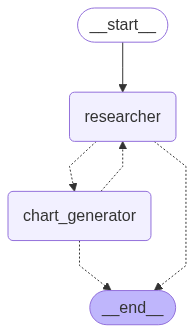

In [6]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    # This requires some extra dependencies and is optional
    raise e


In [7]:
events = graph.stream(
    {
        "messages": [
            (
                "user",
                "First, get the UK's GDP over the past 5 years, then make a line chart of it. "
                "Once you make the chart, finish.",
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)

{'researcher': {'messages': [HumanMessage(content="First, get the UK's GDP over the past 5 years, then make a line chart of it. Once you make the chart, finish.", additional_kwargs={}, response_metadata={}, id='5d7e74df-7107-4d18-91ba-a9097a0b8311'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search', 'arguments': '{"query": "UK GDP over the past 5 years"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--eb5f2f6d-8f7d-4a99-a6c5-292572ae1d95-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'UK GDP over the past 5 years'}, 'id': 'b2308180-a15a-46f5-9a54-c003d4805586', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1373, 'output_tokens': 202, 'total_tokens': 1575, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 178}}), ToolMessage(content='{"query": "UK GDP over the past 5 years", "

Python REPL can execute arbitrary code. Use with caution.


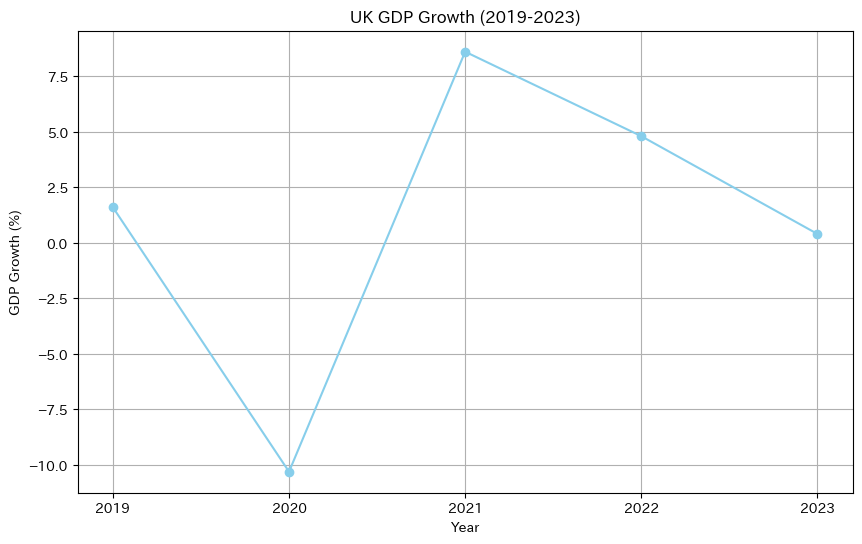

{'chart_generator': {'messages': [HumanMessage(content="First, get the UK's GDP over the past 5 years, then make a line chart of it. Once you make the chart, finish.", additional_kwargs={}, response_metadata={}, id='5d7e74df-7107-4d18-91ba-a9097a0b8311'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search', 'arguments': '{"query": "UK GDP over the past 5 years"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--eb5f2f6d-8f7d-4a99-a6c5-292572ae1d95-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'UK GDP over the past 5 years'}, 'id': 'b2308180-a15a-46f5-9a54-c003d4805586', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1373, 'output_tokens': 202, 'total_tokens': 1575, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 178}}), ToolMessage(content='{"query": "UK GDP over the past 5 year

Task chart_generator with path ('__pregel_pull', 'chart_generator') wrote to unknown channel branch:to:__end__, ignoring it.


{'chart_generator': {'messages': [HumanMessage(content="First, get the UK's GDP over the past 5 years, then make a line chart of it. Once you make the chart, finish.", additional_kwargs={}, response_metadata={}, id='5d7e74df-7107-4d18-91ba-a9097a0b8311'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search', 'arguments': '{"query": "UK GDP over the past 5 years"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--eb5f2f6d-8f7d-4a99-a6c5-292572ae1d95-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'UK GDP over the past 5 years'}, 'id': 'b2308180-a15a-46f5-9a54-c003d4805586', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1373, 'output_tokens': 202, 'total_tokens': 1575, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 178}}), ToolMessage(content='{"query": "UK GDP over the past 5 year

In [8]:
for s in events:
    print(s)
    print("----")
